In [69]:
from scipy.stats import probplot
from scipy.io import loadmat
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys, os
from utils import *
import math
mpl.rcParams['figure.dpi']= 1800
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Building Models of Spike Train Data

Prepared by Josefina Correa

### _Overview_
#### In this tutorial, we will be analyzing the firing activity of a retinal ganglion cell in cuture, exposed to low-light and high-light  environments. The aims of the tutorial follow:

* To visualize spike-train data
* To compute and interpret summary statistics
* To build models of the inter-spike-interval distribution as a function of the light level
* To 

### Background

#### The scientific question at hand

Neurons in the retina respond to patterns of light. When retinal ganglion cells are grown in culture and held under constant environmental conditions, these neurons exhibit spontaneous firing activity. A researcher extracted the retina from goldfish and sustained them in culture and performed electrophysiological recordings under two conditions: low ambient light levels and high ambient light levels. The aim of the study was to characterize the variability of the goldfish ganglion cell firing due to the common noise source, the background light level. [1]


#### Neural spike trains as point processes

Point processes can be considered, approximately, to be a binary time series. They can be described in terms of the event times,  inter-event intervals or the number of events that occur. When describing a set of spikes according to the inter-event intervals, we define the interspike intervals as the length of time between one event and the next. These processes can exhibit a variety of history dependent behaviors. The simplest type of point process is a poisson process.

***Poisson processes*** are point processes that are memoryless: the probability of an event happening at a particular time is independent on the occurrence or timing of past events. Homogeneous Poisson processes describe irregular sequences of events that lack a temporal structure. There is a theorem that states that a point process is a homogeneous Poisson process with rate $\lambda$ if and only if the inter-event waiting times are independent, identically distributed exponential variables with rate $\lambda$. We will begin this tutorial by considering the exponential distribution as a plausible model for the interspike intervals. 

We will see, however, that the temporal structure of inter-events is relevant because we are often interested in measuring how spiking activity changes with respect to a stimulus. For this reason, the history or previous neural activity influences the spiking activity over time. We will explore this by examining how well the inverse gaussian distribution describes the data.

For a more detailed description of point processes and their use for analyzing neural data, check out Dr. Uri Eden's <a href = "http://www.stat.columbia.edu/~liam/teaching/neurostat-fall18/uri-eden-point-process-notes.pdf">point process notes.</a>


## Application

In order to assess whether there is a difference between the interspike intervals for the retinal ganglion cells between these two conditions, we will model the distribution of the interspike intervals. 

### Loading the data

The file 'Ch8-spikes-1.mat' in the directory 'Case-Studies-Kramer-Eden/Chapter8' contains a set of spike-times for two retinal ganglion cells, one exposed to low-level ambient light and another to high-level ambient light. For this tutorial, I have defined a library called utils with general purpose functions to help assist the learning process. In order to load the data, run the following line of code. You will see that ``retinal_ganglion_data_dict`` is a python dictionary with keys ``SpikesLow`` and ``SpikesHigh``. Both of these lists have units in seconds.

In [2]:
retinal_ganglion_data_path = '../Case-Studies-Kramer-Eden/Chapter8/Ch8-spikes-1.mat'
retinal_ganglion_data_dict = load_retinal_ganglion_data(retinal_ganglion_data_path)
print(retinal_ganglion_data_dict.keys())
spike_train_low = retinal_ganglion_data_dict['SpikesLow']
spike_train_high= retinal_ganglion_data_dict['SpikesHigh']


dict_keys(['SpikesLow', 'SpikesHigh'])


### Exploratory Data Analysis

#### Comparing firing rates

One of the fundamental tenants of neuroscience is that neurons respond to a stimulus by increasing their 'firing rate', the number of spikes that occur per unit time:
<h3></h3>
\begin{align*}FR = \frac{\text{number of spikes}}{\Delta t}\end{align*}
<h3></h3>

Given that we have a dataset for which the neuron was exposed to a higher level of light, we can start by exploring whether the firing rate of this neuron is higher under the high light condition than under the low light condition.

#### Computing the average firing rate. 

In order to compute the average firing rate, we need to find the number of events that occurred over the duration of the experiment. The lists ``spike_train_low``  and ``spike_train_high`` contain the times where these events occurred. Write a function to obtain the number of spikes that occurred for the low and high conditions. Use this function to compute the average firing rate for the duration of the experiment (30 seconds).

In [3]:
def num_spikes(spike_train):
    return len(spike_train)

def mean_FR(spike_train):
    spikes = num_spikes(spike_train)
    time_bin= len(spike_train)
    return spikes / spike_train[-1]

In [4]:
mean_FR_high= mean_FR(spike_train_high)
mean_FR_low = mean_FR(spike_train_low)

print('Average Firing Rate for the low light condition: ',\
      mean_FR_low  , 'spikes per second')
print('Average Firing Rate for the high light condition:', \
      mean_FR_high , 'spikes per second')


Average Firing Rate for the low light condition:  25.00735071928208 spikes per second
Average Firing Rate for the high light condition: 32.32745234395914 spikes per second


#### Visualizing spike trains

The firing rate has a downfall: its value depends on the interval for which it is computed and on the time interval used for its calculation. This can be seen by looking at the raster plots for the neural activity. A raster plot shows the occurrence of a spike for a sequence of times, the temporal duration of the experiment, for instance. This sequence is called a ***spike train***. A neural spike train represents the time series of spikes that occurred during a recording session. 

The following sections show raster plots for the spiking activity for the two conditions. Each row has as x axis the time in seconds, and each vertical blue line represents a spike. 

Take a look at the spike trains below. What do these spike trains suggests as possible hypotheses worth exploring in the data? 

What information is lost in the average firing rate that is suggested by the spike train?

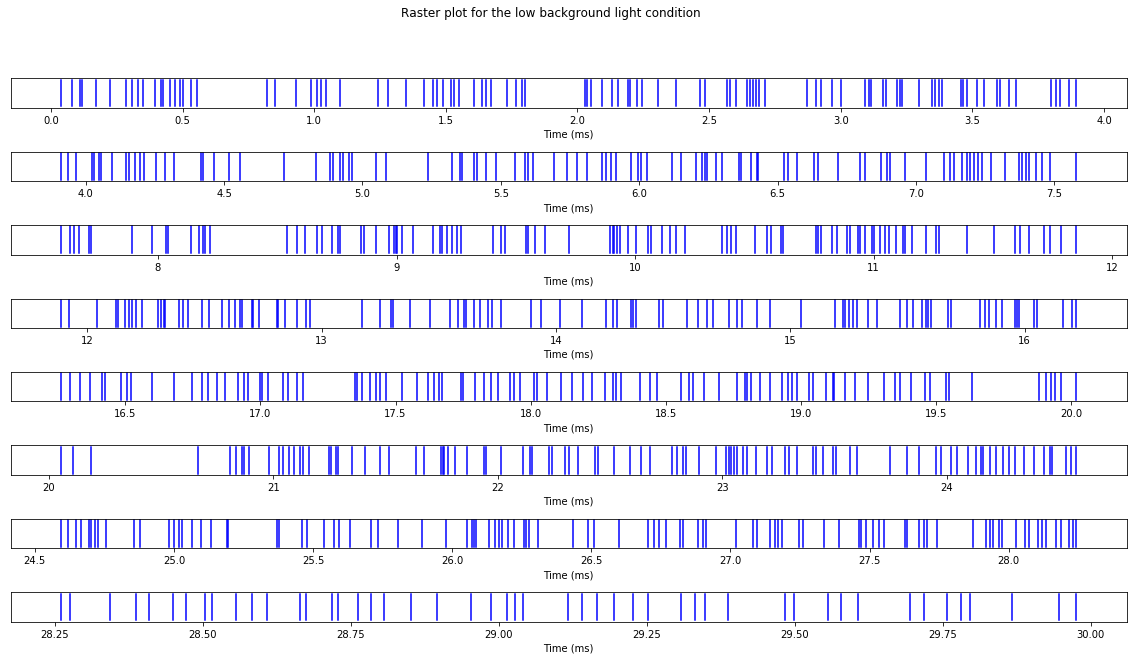

In [5]:
make_raster_plot(spike_train_low, \
'Raster plot for the low background light condition')

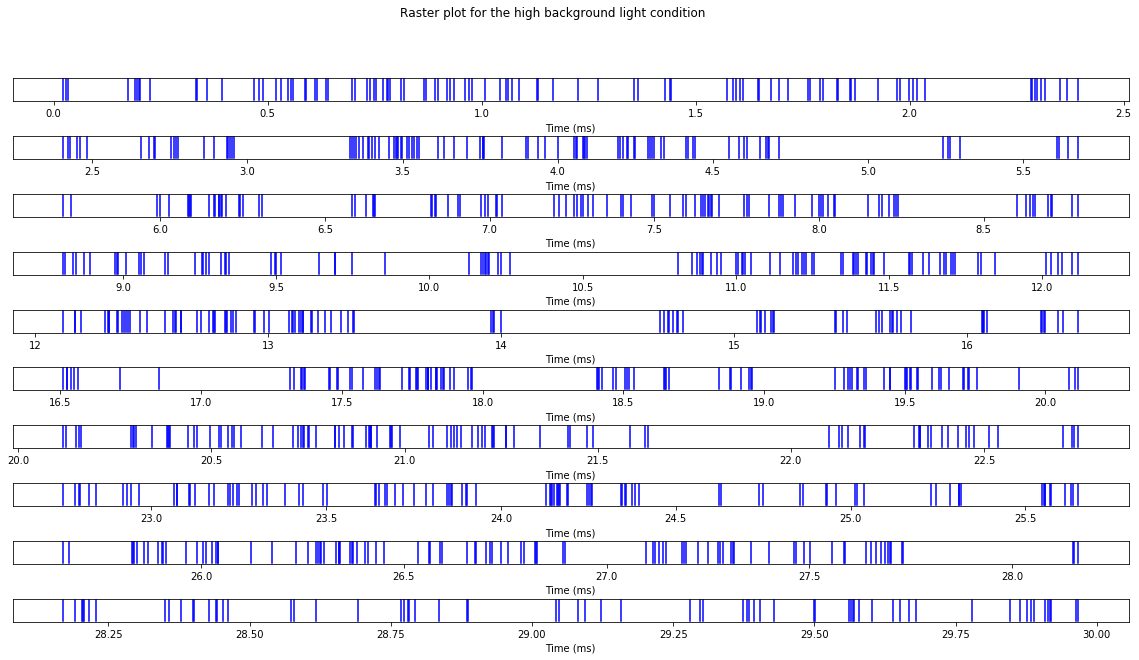

In [6]:
make_raster_plot(spike_train_high, \
'Raster plot for the high background light condition')

### The interspike interval

One possible hypothesis worth exploring is whether there is a difference in the inter-event times. That is, the spike trains suggest that, for the high light condition, there are some segments where the neuron seems to have a higher firing rate, and other segments where the neuron has a lower firing rate. We can explore this by computing the inter-event times, which for neural data are called the interspike intervals. 

In order to compare the inter-event times between the low ambient light condition and the high ambient light condition, we first need to compute the inter-spike intervals. The inter-spike intervals are the waiting times between the spike times. 

**Write a function that takes as input the list of spike times and returns as output the amount of time between each of the spike times**

In [7]:
def compute_inter_spike_intervals(spike_times):
    ISIs = [spike_times[i] - spike_times[i-1] for i in range(1,len(spike_times))]
    return ISIs

Run the following code segment to visualize the empirical distribution of interspike times for each of the light conditions. What do these histograms suggest? 

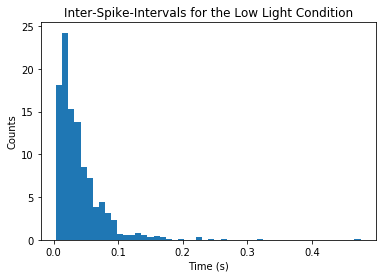

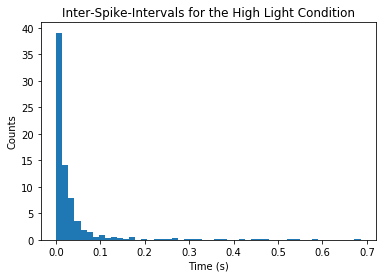

In [8]:
spike_trains_high = retinal_ganglion_data_dict['SpikesHigh']
spike_trains_low  = retinal_ganglion_data_dict['SpikesLow']
n_bins      = 50
plot_title1 = 'Inter-Spike-Intervals for the High Light Condition'
plot_title2 = 'Inter-Spike-Intervals for the Low Light Condition'

low_ISIs    = compute_inter_spike_intervals(spike_trains_low)
high_ISIs   = compute_inter_spike_intervals(spike_trains_high)

plot_ISIs(low_ISIs,  n_bins, plot_title2)
plot_ISIs(high_ISIs, n_bins, plot_title1)

### Building Statistical Models of the Inter-Spike-Intervals

In order to investigate whether there is a difference in the inter-spike-intervals for the two conditions, we need a statistical model. We will investigate which of the following distributions best describes the data. We will explore the **exponential** and **inverse Gaussian** distributions.   

In order to do so, we will compare the model probability density estimates to the normalized histograms of the Inter-Spike Intervals. Let's start with the exponential distribution.

### The exponential distribution

An **exponential random variable** is a continuous random variable on the interval $[0, \infty)$ and has probability density function given by

\begin{align}
f_x(x) = P(0\leq X \leq \infty) & = \int_0^\infty \! \lambda e^{-\lambda x} \, \mathrm{d}x.  
\end{align}

Its cumulative density function is given by

\begin{align}
F_x(x) = P(X \leq x) & = \int_0^x \! 1 - \lambda e^{-\lambda x} \, \mathrm{d}x.  
\end{align}

It is a useful distribution for describing waiting times that are **memoryless**, where the next waiting time can be thought of as being independent of the previous waiting times. Furthermore, it has a **rate parameter** $\lambda > 0$. 
  
The following functions will allow you to visualize the exponential PDF and CDF for different $\lambda$ values. Take a look at how the shape of the distribution changes for different parameters $\lambda$. This parameter is the ***rate*** parameter and must be greater than 0.

**Create a vector of different $\lambda$ parameters and an array of x values. Then, run the following line of code to visualize the PDF and the CDF for the corresponding $\lambda$ parameters.**

***Hint: the function <a href = "https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html">np.arange</a> is useful for creating arrays within a particular range and at specific increments***

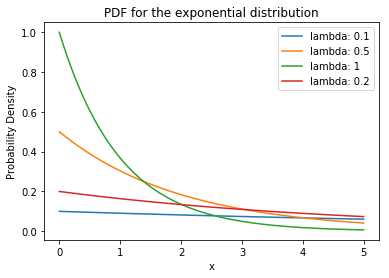

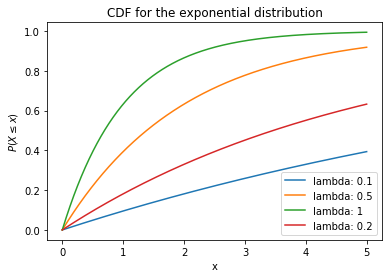

In [9]:
lambdas   = [0.1, 0.5, 1, 0.2]
x_vals    = np.arange(0,5,0.001)

exponential_pdf = lambda x, lam: lam * np.exp(-x*lam)
exponential_cdf = lambda x, lam: 1 - np.exp(-x*lam)

plot_exponential_dist( exponential_pdf, x_vals, lambdas, 1) 
plot_exponential_dist( exponential_cdf, x_vals, lambdas, 0)

Our goal now is to find an appropriate rate parameter $\lambda$ for which to model the interspike intervals for the two light conditions. In order to explore which $\lambda$ parameters might be reasonable, we can overlay the exponential PDF over the **empirical probability distribution**. To compute the empirical probability distribution, we will define small time bins (1ms) and will count the number of times that a given interspike interval falls within each of these time bins. 

**Compute the empirical probability distribution for 1000ms time bins and overlay the probability density function for the exponential distribution for different $\lambda$s. Which $\lambda$ best fits the observed ISI distribution?**

***Hint: create a vector that goes from 0 to 0.5 in 0.001 increments. Look at the documentation for <a href= "https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.histogram.html">np.histogram</a> in order to compute the number of times that the interspike intervals fall within each of these bins***

Text(0.5, 1.0, 'ISI histogram vs exponential model for the low-light condition')

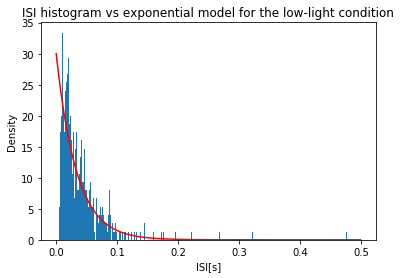

In [10]:
ISI  = low_ISIs
lam  = 30
ISIs = low_ISIs
bins = np.arange(0,0.5,0.001)

plt.plot(bins, exponential_pdf(bins, lam),'r')
plt.hist(ISIs, bins, density=True)
plt.ylabel('Density')
plt.xlabel('ISI[s]')
plt.title('ISI histogram vs exponential model for the low-light condition')

Text(0.5, 1.0, 'ISI histogram vs exponential model for the high-light condition')

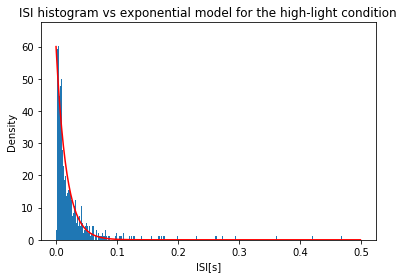

In [11]:
ISI  = high_ISIs
lam  = 60
ISIs = high_ISIs
bins = np.arange(0,0.5,0.001)

plt.plot(bins, exponential_pdf(bins, lam),'r')
plt.hist(ISIs, bins, density=True)
plt.ylabel('Density')
plt.xlabel('ISI[s]')
plt.title('ISI histogram vs exponential model for the high-light condition')

### The method of maximum likelihood maximizes the likelihood function

If we make the assumption that the interspike intervals are independent, and that they are exponentially distributed, then the joint probability distribution of the observed data is given by:

\begin{align}
f(x_1,x_2,\cdots,x_n)
& = f(x_1)f(x_2) \cdots f(x_n) \\
& = \lambda e^{-\lambda x_1 } \lambda e^{-\lambda x_2} \cdots \lambda e^{-\lambda x_n }  \\
& = \lambda^n e^{ -\lambda \sum_{i=1}^{n}{x_i} }
\end{align}

Here, we are considering the PDF as a function of the parameter $\lambda$, rather than as a function of the random variable $x$. In this scenario, $f(x|\lambda)$ is considered the **likelihood function** and we will denote it by $L(\lambda)$. The value of $\lambda$ that maximizes the probability of the data is termed the **maximum likelihood estimator** of $\lambda$. Notationally, we write it as $\hat{\lambda}$.  

We can determine the value of $\lambda$ that maximizes the probability of the data through **Maximum Likelihood** methods. That is, we take the derivative of the likelihood function, set it to zero, and solve for $\lambda$. Since often times, the values for $L(\lambda)$ are quite large, it is convenient to take the logarithm and maximize the log-likelihood function $log(L(\lambda)) = \ell(\lambda)$. 

Let's compute the value of $\hat{\lambda}$ analytically:

\begin{align}
\ell (\lambda)
& = log( L(\lambda) ) \\
& = log( \lambda^n e^{ -\lambda \sum_{i=1}^{n}{x_i} } ) \\
& = n log(\lambda) - \lambda \sum_{i=1}^{n}{x_i} \\
\frac{\partial \ell (\lambda) }{\partial \lambda}
& = \frac{n}{\lambda} - \sum_{i=1}^{n}{x_i} = 0 \\
\Rightarrow
\hat{\lambda} &= \frac{n}{\sum_{i=1}^{n}{x_i} } \\
\end{align}

**Plot the log-likelihood function $\ell (\lambda)$ for different values of $\lambda$ and compute the maximum likelihood estimate $\hat{\lambda}_{ML}$ for the low-light and the high-light conditions. Compare the analytical estimate to the maximum value of the log-likelihood plot.**

***Hint: for getting the maximum value of the line below, use the function ``np.argmax(log_lik)``, which will return the index corresponding to the maximum value of ``lambda_vals``, where ``lambda_vals`` is a vector of the lambdas for which you are plotting the log-likelihood function***

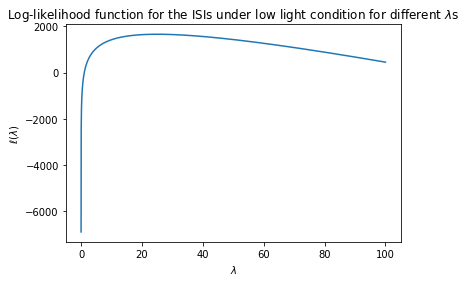

ML estimate for the low-light condition:    25.0073


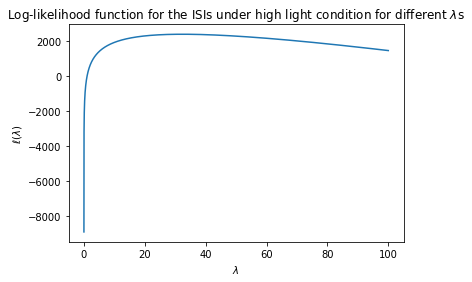

 ML estimate for the high light condition :  32.3186


In [38]:
log_lik_fun = lambda lam, x: \
              (len(x) * np.log(lam.T)) - (lam.T*sum(x))
lambda_vals = np.arange(0.0001,100,0.0001)
log_lik = log_lik_fun(lambda_vals, low_ISIs)
plt.plot(lambda_vals, log_lik)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\ell (\lambda)$')
plt.title(r'Log-likelihood function for '\
          'the ISIs under low light condition '\
          'for different $\lambda$s')
plt.show()
max_lambda = lambda_vals[np.argmax(log_lik)]
print('ML estimate for the low-light condition:   ' , max_lambda)

log_lik_fun = lambda lam, x: \
              (len(x) * np.log(lam.T)) - (lam.T*sum(x))
lambda_vals = np.arange(0.0001,100,0.0001)
log_lik = log_lik_fun(lambda_vals, high_ISIs)
plt.plot(lambda_vals, log_lik)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\ell (\lambda)$')
plt.title(r'Log-likelihood function for '\
          'the ISIs under high light condition '\
          'for different $\lambda$s')
plt.show()
max_lambda = lambda_vals[np.argmax(log_lik)]
print(' ML estimate for the high light condition : ' , max_lambda)

**Now, overlay the probability density function for the exponential distribution with the $\hat{\lambda}_{ML}$ estimates and the binned counts from the previous section. How do these distributions differ?**

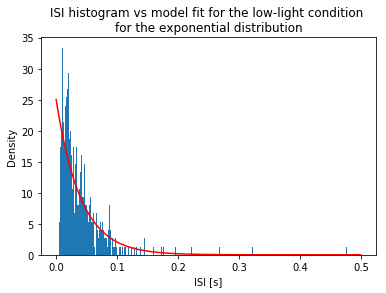

In [13]:
lam_ml_exp_low_isis = len(low_ISIs)/sum(low_ISIs)

ISIs = low_ISIs
bins = np.arange(0,0.5,0.001)

plt.plot(bins, exponential_pdf(bins, lam_ml_exp_low_isis),'r')
plt.hist(low_ISIs, bins, density=True)

plt.xlabel('ISI [s]')
plt.ylabel('Density')
plt.title('ISI histogram vs model fit'\
          ' for the low-light condition ' \
          '\nfor the exponential distribution')
plt.show()

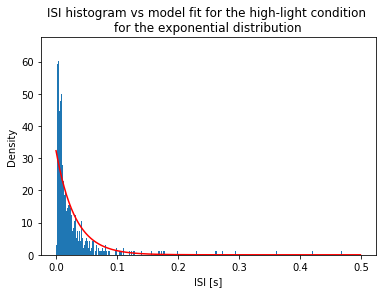

In [14]:
lam_ml_exp_high_ISIs = (len(high_ISIs)/sum(high_ISIs))

ISIs = high_ISIs

bins = np.arange(0,0.5,0.001)

plt.plot(bins, exponential_pdf(bins, lam_ml_exp_high_ISIs),'r')
plt.hist(ISIs, bins, density=True)

plt.xlabel('ISI [s]')
plt.ylabel('Density')
plt.title('ISI histogram vs model fit'\
          ' for the high-light condition ' \
          '\nfor the exponential distribution')
plt.show()

### Scientific inference requires having a notion of precision over the estimates.

Confidence intervals allow for quantifying our certainty about our estimate. 

<p><div align = "center"> "A 95% confidence interval (CI) for a parameter $\theta$ is an interval of the form $(L, U)$, (L for lower, U for upper), where $L = L(X_1, \cdots , X_n)$ and $U = U(X_1, \cdots, X_n)$ are random variables derived from the data and $P(L \le \theta \le U) = 0.95\%$" -Analysis of Neural Data, Brown <it> et. al</it>.</div></p>   

This statement implies that if $\theta$ were the true value, then the probability that the interval $(L, U)$ contains the $\theta$ is approximately 95%. This does **not** imply that, based on the data, the probability that $(L, U)$ contains $\theta$ is 95%. Think about this statement. Can you see why the two are different? Another way of interpreting confidence intervals is to draw ***N*** random samples independently and to compute the CIs for each sample. If we do this many times, at the limit, approximately 95% of those CIs would contain $\theta$, if $\theta$ is the true value of the estimate. Now that we have computed $\hat{\theta}_{ML}$, we want to determine our level of uncertainty over this estimate. We can do so through the **parametric bootstrap**. The parametric bootstrap involves generating pseudo-data from an estimated parametric distribution. 
   
The algorithm follows.

Let $X = x_1, \dots, x_n$ be a set of data with $N$ datapoints.   

Choose $G$ to be the number of samples of pseudo-data to generate.    
We want G to be large (i.e. pick 10,000).  

**do**  
For $g = 1:G$

   Draw a random sample $U^{(g)} = u_1, \dots, U_n$ from the distribution with pdf $f(x_i|\hat{\lambda})$.

   Compute $\hat{\theta}^{(g)}_{ML}$ based on the bootstrap sample $U^{(g)}$.

   Set $W^{(g)} = \hat{\lambda}^{(g)}$

**end**
    
Compute $\bar{W} = \frac{1}{G}\sum_{i=1}^{G}{W^{(g)}}$  

Sort $W^{(g)}$ in ascending order

Compute the 95% Confidence intervals as the 25th and 95th element of the sorted vector of $W^{(g)}$

**Perform a parametric boostrap procedure to compute $\hat{\lambda}_{ML}$ for the exponential distribution, along with its 95% confidence intervals. Can you think of a way to test whether the model parameters are different for the low light condition versus the high light condition?**

In [15]:
#Define a confidence level
alpha   = 0.05
#Define the number of Monte Carlo samples to generate
G       = 10000
#Define the size of each pseudo-data
X_low   = len(low_ISIs)
X_high  = len(high_ISIs)
#Define the indexes for the upper and lower confidence
#intervals
uci_idx = int(((1-alpha)*G))
lci_idx = int((alpha * G))

Bootstrap estimate:          32.305520928426844
Maximum Likelihood estimate:  32.31855759655577


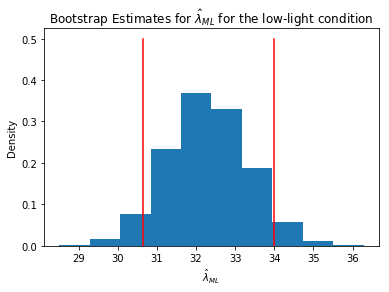

In [39]:
ISIs    = high_ISIs
W_high  = np.zeros(G)
for g in range(G):
    lambda_hat_ml_exp = 1/np.mean(ISIs)
    N_pseudo_samples  = len(ISIs)
    curr_pseudo_data  = np.random.exponential(lambda_hat_ml_exp, \
                                             (1, N_pseudo_samples))
    curr_lambda_hat   = np.mean(curr_pseudo_data)
    W_high[g]         = curr_lambda_hat
sorted_Ws             = np.sort(W_high)
lambda_hat_boot       = np.mean(W_high)
lci_lambda_hat_boot   = sorted_Ws[lci_idx]
uci_lambda_hat_boot   = sorted_Ws[uci_idx]
print('Bootstrap estimate:         ' , lambda_hat_boot)
print('Maximum Likelihood estimate: ', lambda_hat_ml_exp)
plt.hist(W_high,density=True)
plt.plot([lci_lambda_hat_boot, lci_lambda_hat_boot], [0, 0.5], '-r')
plt.plot([uci_lambda_hat_boot, uci_lambda_hat_boot], [0, 0.5], '-r')
plt.ylabel('Density')
plt.xlabel(r'$\hat{\lambda}_{ML}}$')
plt.title('Bootstrap Estimates for $\hat{\lambda}_{ML}$ for the low-light condition')
plt.show()

Bootstrap estimate:          24.999598417901314
Maximum Likelihood estimate:  25.007253801355365


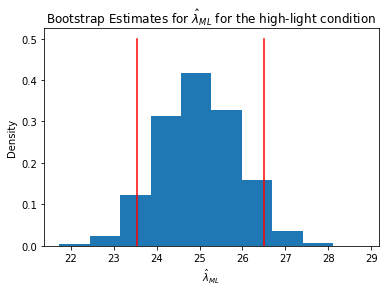

In [40]:
ISIs  = low_ISIs
W_low = np.zeros(G)
for g in range(G):
    lambda_hat_ml_exp = 1/np.mean(ISIs)
    N_pseudo_samples  = len(ISIs)
    curr_pseudo_data  = np.random.exponential(lambda_hat_ml_exp, \
                                              (1, N_pseudo_samples))
    curr_lambda_hat   = np.mean(curr_pseudo_data)
    W_low[g]          = curr_lambda_hat
sorted_Ws             = np.sort(W_low)
lambda_hat_boot       = np.mean(W_low)
lci_lambda_hat_boot   = sorted_Ws[lci_idx]
uci_lambda_hat_boot   = sorted_Ws[uci_idx]
print('Bootstrap estimate:         ' , lambda_hat_boot)
print('Maximum Likelihood estimate: ', lambda_hat_ml_exp)
plt.hist(W_low,density=True)
plt.plot([lci_lambda_hat_boot, lci_lambda_hat_boot], [0, 0.5], '-r')
plt.plot([uci_lambda_hat_boot, uci_lambda_hat_boot], [0, 0.5], '-r')
plt.ylabel('Density')
plt.xlabel(r'$\hat{\lambda}_{ML}}$')
plt.title('Bootstrap Estimates for $\hat{\lambda}_{ML}$ '\
          'for the high-light condition')
plt.show()

### Is the difference between the $\hat{\lambda}_{ML}$ estimates for the low-light and high-light conditions statistically significant?

In order to answer this question, we can perform a **parametric bootstrap procedure**. That is, we will estimate $\lambda$ by drawing N random samples with replacement from both estimated distributions. Each random draw will be a vector of the size of the data. We will compute the ML estimate for each random draw. This will give us a distribution of the ML estimates over the data. We can then compare the two distributions for the ISIs under high light condition and under low light condition. To do so, we can use the numpy function <a href = "https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html"> np.random.choice </a>, which takes as input a vector, the number of samples, and a boolean corresponding to whether to sample with replacement or not. We want to sample with replacement.

Now that we have a distribution for the ML estimate for each of the conditions, we can compare these distributions to determine whether the difference between the two parameters is statistically significant. 


**Compute the difference between these samples. What are the confidence intervals for the difference between the two distributions? Do the confidence intervals for the difference include 0?** 

***Answer: Since the confidence intervals for the difference between the two bootstrap estimates for the Poisson rate parameter do not include 0, the difference between the Poisson rate parameters is significant***

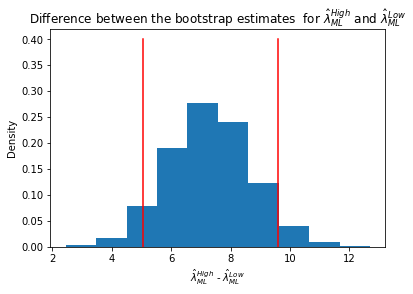

In [41]:
W_diffs = W_high - W_low
sorted_lambda_diffs = np.sort(W_diffs)
uci_lambda_diffs = sorted_lambda_diffs[uci_idx]
lci_lambda_diffs = sorted_lambda_diffs[lci_idx]
plt.hist(W_diffs,density=True)
plt.plot([lci_lambda_diffs, lci_lambda_diffs],[0, 0.40], '-r')
plt.plot([uci_lambda_diffs, uci_lambda_diffs],[0, 0.40], '-r')
plt.title('Difference between the bootstrap estimates '\
          ' for $\hat{\lambda}_{ML}^{High}$ and '
          '$\hat{\lambda}_{ML}^{Low}$')
plt.xlabel('$\hat{\lambda}_{ML}^{High}$ - $\hat{\lambda}_{ML}^{Low}$')
plt.ylabel('Density')
plt.show()

### Goodness of fit: how well does the model describe the data?

A way of checking whether a set of data comes from, approximately, a particular probability model, is to generate **Quantile-Quantile Plots**. Quantile quantile plots allow for comparing the observed quantiles of the data to the theoretical quantiles of the probability distribution. To do so, we sort

Let $X$ be an array containing the data. To compute the observed quantiles, we sort the data in ascending order, $x_{(1)}, \dots, x_{(r)}$ and then say that $x_{(r)}$  is the quantile of order $\frac{r}{(n+1}$, also called the $\frac{100r}{(n+1)}$ percentile. We want to see whether the data are a sample from a distribution having a CDF $F(x)$ then we may define the set of quantile $y_(r) = F^{-1}\frac{r}{(n+1)}$, for $r = 1, \dots , n$, where $n$ is the number of elements in the data set. 

**Write down the formula for the inverse CDF for the exponential distribution and write a function that takes as input a list and returns the theoretical quantiles for the exponential distribution. Then, plot the sorted items of the data against the theoretical quantiles. Check your understanding of the process by comparing your plot to the line of code below. Is the exponential distribution a good model for the data? Why, or why not?** 

***We can see from the QQ-plots that the exponential model does not describe the ISIs for either the low or the high light condition well.***

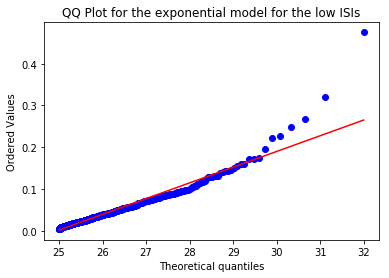

In [42]:
from scipy.stats import probplot
from scipy import stats
lam_ml_exp_low_isis= len(low_ISIs)/sum(low_ISIs)

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
res = stats.probplot(low_ISIs, \
                     dist=stats.expon, \
                     sparams=(lam_ml_exp_low_isis,), plot=ax)
plt.title('QQ Plot for the exponential model for the low ISIs')
plt.show()

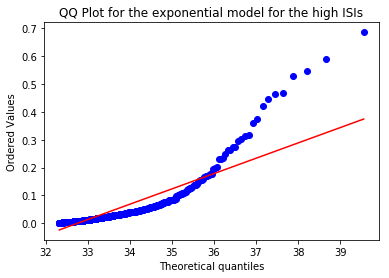

In [43]:
from scipy.stats import probplot
from scipy import stats
lam_ml_exp_high_isis= len(high_ISIs)/sum(high_ISIs)

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
res = stats.probplot(high_ISIs, \
                     dist=stats.expon, \
                     sparams=(lam_ml_exp_high_isis,), plot=ax)
plt.title('QQ Plot for the exponential model for the high ISIs')
plt.show()

Another way of assessing goodness of fit is through Kolmogorov-Smirnov plots, which plot the theoretical CDF against the empirical CDF. If this line falls within the confidence bounds, we can state that the model fits the data well. From the following KS plots below, we can see another confirmation of the results above.

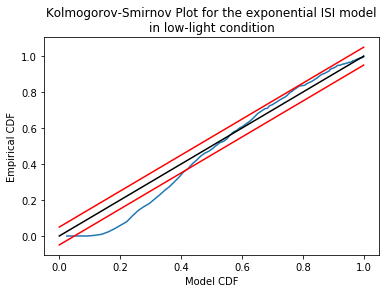

In [44]:
lam_ml_exp_low_isis= len(low_ISIs)/sum(low_ISIs)
ISIs = low_ISIs
N    = len(ISIs)
bins = np.arange(0,0.5,0.001)

upper_ks_cis = np.linspace(0,1,N) + 1.36 / np.sqrt(N)
lower_ks_cis = np.linspace(0,1,N) - 1.36 / np.sqrt(N)

counts, _, _ = plt.hist(ISIs, bins, density=False)
plt.close()
len(counts)
condition = 'low-light'
model     = 'exponential'
probs = counts / sum(counts)
low_isis_empirical_cdf = np.cumsum(probs)
low_isis_model_cdf_exp = exponential_cdf(bins,lam_ml_exp_low_isis)
plt.plot(low_isis_model_cdf_exp[1:], low_isis_empirical_cdf)
plt.plot([0,1], [0,1],'-k')
plt.plot(np.linspace(0,1,N), upper_ks_cis,'-r')
plt.plot(np.linspace(0,1,N), lower_ks_cis,'-r')
plt.title('Kolmogorov-Smirnov Plot for the '+ model +' ISI model' \
          '\nin ' + condition + ' condition')
plt.ylabel('Empirical CDF')
plt.xlabel('Model CDF')
plt.show()

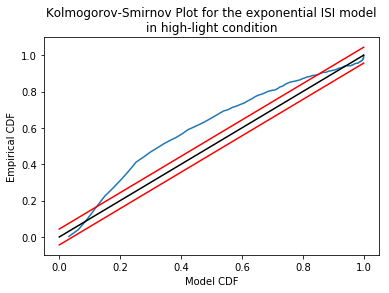

In [45]:
lam_ml_exp_high_isis= len(high_ISIs)/sum(high_ISIs)
ISIs = high_ISIs
N    = len(ISIs)
bins = np.arange(0,0.5,0.001)

upper_ks_cis = np.linspace(0,1,N) + 1.36 / np.sqrt(N)
lower_ks_cis = np.linspace(0,1,N) - 1.36 / np.sqrt(N)

counts, _, _ = plt.hist(ISIs, bins, density=False)
plt.close()
len(counts)
condition = 'high-light'
model     = 'exponential'
probs = counts / sum(counts)
high_isis_empirical_cdf = np.cumsum(probs)
high_isis_model_cdf_exp = exponential_cdf(bins,lam_ml_exp_high_isis)
plt.plot(high_isis_model_cdf_exp[1:], high_isis_empirical_cdf)
plt.plot([0,1], [0,1],'-k')
plt.plot(np.linspace(0,1,N), upper_ks_cis,'-r')
plt.plot(np.linspace(0,1,N), lower_ks_cis,'-r')
plt.title('Kolmogorov-Smirnov Plot for the '+ model +' ISI model' \
          '\nin ' + condition + ' condition')
plt.ylabel('Empirical CDF')
plt.xlabel('Model CDF')
plt.show()

### The inverse Gaussian distribution

We know from physiology that neurons have an absolute refractory period. That is, once a neuron spikes, it cannot do so again for a certain amount of time. This means that the spikes are **not** independent events. A distribution that can be used for modelling this is the inverse Gaussian distribution. 

The inverse gaussian distribution has PDF


Am **inverse gaussian random variable** is a continuous random variable on the interval $[0, \infty)$ and has probability density function given by

\begin{align}
f_x(x) = P(0\leq X \leq \infty) & = \int_0^\infty \! \sqrt{\frac{\lambda}{2 \pi x ^3}}e^{\frac{-\lambda(x-\mu)^2}{2 \mu^2 x}}\, \mathrm{d}x.  
\end{align}

Its cumulative density function is given by

\begin{align}
F_x(x) = P(X \leq x) & = \int_0^x \! \Phi\Bigg(\sqrt{\frac{\lambda}{x}} \frac{x}{\mu}-1\Bigg) + e^{\frac{2\lambda}{\mu}} \Phi \Bigg(-\sqrt{ \frac{\lambda}{x} } \Bigg) \mathrm{d}x.  
\end{align}

where $\Phi$ is the <a href = "http://mathworld.wolfram.com/NormalDistributionFunction.html">standard normal gaussian CDF </a>, $\mu > 0$ , $\lambda > 0$ and $x \in (0, \infty)$.


**Generate different $\lambda$ and $\mu$ parameters and visualize the shape of the PDF for the Inverse Gaussian Distribution and for its CDF. How does the shape compare to that of the exponential distribution? Overlay the Probability Density Functions for the two distributions. Which one do you think will describe the data best?**

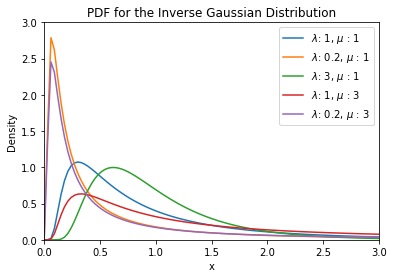

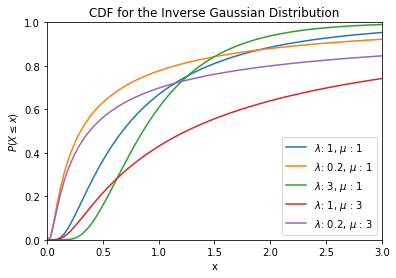

In [46]:
inv_gauss_pdf = lambda x, lam, mu: \
                (lam/ (2*math.pi*(x**3))) ** 0.5 \
                * np.exp( np.divide( (-lam * ((x - mu)**2)), (2*x*(mu**2))))
inv_gauss_cdf = lambda x, lam, mu: norm.cdf(np.sqrt(np.divide(lam,x)) \
                                            * (np.divide(x,mu)-1)) + \
                                            (np.exp(np.divide(2*lam,mu)) * \
                                             norm.cdf(-np.sqrt(np.divide(lam,x))*\
                                                      (np.divide(x,mu)+1)))

lambdas = [1,0.2,3,1,0.2]
mu_vals = [1,1,1,3,3]
x_vals  = np.linspace(0.000001,3,100)
plot_igauss_dist(inv_gauss_pdf, x_vals, lambdas, mu_vals, 1, [0, 3])
plot_igauss_dist(inv_gauss_cdf, x_vals, lambdas, mu_vals, 0, [0, 3])

We can see that the inverse gaussian distribution has two parameters that determine its shape, $\lambda$ and $\mu$. As with the exponential distribution, we can compute the maximum likelihood solution for the model, which will be the pair of parameter estimates $\hat{\mu}$ and $\hat{\lambda}$ that maximize the likelihood of the data.

If we assume that the interspike intervals are independent of eachother, the likelihood function is given by:

$L(\mu, \lambda) = \Pi_{i=1}^{N}\sqrt{\frac{\lambda}{2 \pi x_{i}^3}}\exp{ \bigg( \frac{-\lambda(x_i-\mu)^2}{2x_{i}\mu^2}\bigg)}, x_i > 0$  

The log-likelihood function is then given by

$\ell (\mu, \lambda) = \frac{N}{2} log \frac{\lambda}{2 \pi} - \frac{3}{2} \sum_{i=1}^{N}log(x_i) - \sum_{i=1}^{N} \frac{\lambda (x_i - \mu)^2}{2x_i \mu^2}$

We can now repeat the steps performed above to assess whether the inverse gaussian distribution fits the data well.


1. Derive the maximum likelihood estimators for $\hat{\mu}$ and $\hat{\lambda}$ by taking the partial derivatives of the log-likelihood function with respect of each of these parameters.

\begin{align}
\hat{\mu} &= \frac{1}{N}\sum_{i=1}^{n}{x_i} \\
\end{align}

\begin{align}
\hat{\lambda} &= \frac{1}{\sum_{i=1}^{n}\bigg({x_i} - \frac{1}{N}\sum_{i=1}^{n}{x_i} \bigg)}  \\
\end{align}


2. Use the function above ``inv_gauss_pdf`` to create a model for the inverse gaussian distribution, using the analytical solution to the maximum-likelihood estimates.

In [47]:
def lambda_hat_igauss(x):
    mu = mu_hat_igauss(x)
    return 1 / np.mean( np.divide(1, x) - np.divide(1,mu))
def mu_hat_igauss(x):
    return sum(x) / len(x)

ml_mu_igauss_high_ISIs  = mu_hat_igauss(high_ISIs)
ml_lam_igauss_high_ISIs = lambda_hat_igauss(high_ISIs)

ml_mu_igauss_low_ISIs   = mu_hat_igauss(low_ISIs)
ml_lam_igauss_low_ISIs  = lambda_hat_igauss(low_ISIs)


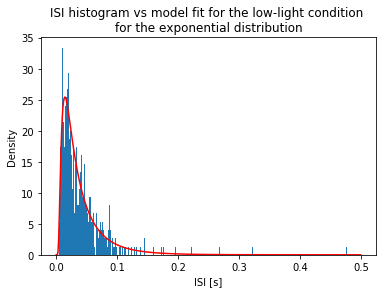

In [48]:
bins = np.arange(0.000001,0.5,0.001)
igauss_pdf_low_ISIs = \
    inv_gauss_pdf(bins, ml_lam_igauss_low_ISIs, ml_mu_igauss_low_ISIs)

ISIs = low_ISIs

plt.plot(bins, igauss_pdf_low_ISIs,'r')
plt.hist(low_ISIs, bins, density=True)

plt.xlabel('ISI [s]')
plt.ylabel('Density')
plt.title('ISI histogram vs model fit'\
          ' for the low-light condition ' \
          '\nfor the exponential distribution')
plt.show()

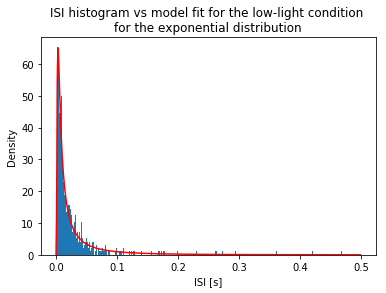

In [49]:
bins = np.arange(0.000001,0.5,0.001)
igauss_pdf_high_ISIs = \
    inv_gauss_pdf(bins, ml_lam_igauss_high_ISIs, ml_mu_igauss_high_ISIs)

ISIs = high_ISIs

plt.plot(bins, igauss_pdf_high_ISIs,'r')
plt.hist(high_ISIs, bins, density=True)

plt.xlabel('ISI [s]')
plt.ylabel('Density')
plt.title('ISI histogram vs model fit'\
          ' for the low-light condition ' \
          '\nfor the exponential distribution')
plt.show()

3. Compute the 95% confidence intervals for the maximum likelihood estimates through the parametric bootstrap procedure.

In [50]:
ISIs    = high_ISIs
N_high  = len(ISIs)

W_high_lam_igauss = np.zeros(G)
W_high_mu_igauss  = np.zeros(G)

for g in range(G):
    lambda_hat_ml_exp = 1/np.mean(ISIs)
    curr_pseudo_data  = np.random.wald(ml_mu_igauss_high_ISIs, \
                                       ml_lam_igauss_high_ISIs, (1,N_high))
    W_high_mu_igauss[g]  = mu_hat_igauss(curr_pseudo_data[0])
    W_high_lam_igauss[g] = lambda_hat_igauss(curr_pseudo_data[0])
    
sorted_mu_boots_igauss_high     = np.sort(W_high_mu_igauss)
sorted_lambda_boots_igauss_high = np.sort(W_high_lam_igauss)

lci_lambda_igauss_high = sorted_lambda_boots_igauss_high[lci_idx]
uci_lambda_igauss_high = sorted_lambda_boots_igauss_high[uci_idx]

lci_mu_igauss_high     = sorted_mu_boots_igauss_high[lci_idx]
uci_mu_igauss_high     = sorted_mu_boots_igauss_high[uci_idx]

lambda_hat_boot_igauss_high  = np.mean(W_high_lam_igauss)
mu_hat_boot_igauss_high      = np.mean(W_high_mu_igauss)

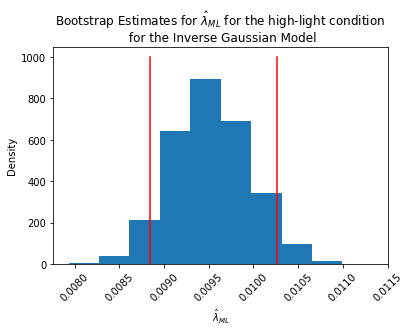

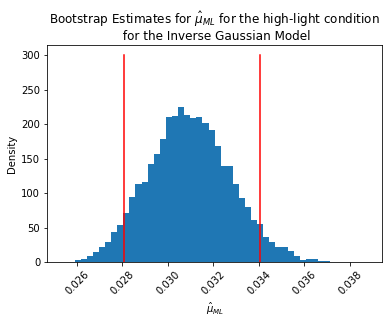

In [68]:
plt.hist(W_high_lam_igauss, density=True)

plt.ylabel('Density')
plt.xlabel('$\hat{\lambda}_{ML}}$')
plt.xticks(rotation=45)
plt.title('Bootstrap Estimates for $\hat{\lambda}_{ML}$ '\
          'for the high-light condition \n for the Inverse Gaussian Model')
plt.plot([lci_lambda_igauss_high, lci_lambda_igauss_high],[0, 1000],'-r')
plt.plot([uci_lambda_igauss_high, uci_lambda_igauss_high],[0, 1000], '-r')
plt.show()

plt.hist(W_high_mu_igauss, 50, density=True)

plt.ylabel('Density')
plt.xlabel('$\hat{\mu}_{ML}}$')
plt.xticks(rotation=45)
plt.title('Bootstrap Estimates for $\hat{\mu}_{ML}$ '\
          'for the high-light condition \n for the Inverse Gaussian Model')
plt.plot([lci_mu_igauss_high, lci_mu_igauss_high],[0, 300],'-r')
plt.plot([uci_mu_igauss_high, uci_mu_igauss_high],[0, 300], '-r')
plt.show()

In [52]:
ISIs    = low_ISIs
N_low   = len(ISIs)

W_low_lam_igauss = np.zeros(G)
W_low_mu_igauss  = np.zeros(G)

for g in range(G):
    curr_pseudo_data  = np.random.wald(ml_mu_igauss_low_ISIs, \
                                       ml_lam_igauss_low_ISIs, (1,N_low))
    W_low_mu_igauss[g]  = mu_hat_igauss(curr_pseudo_data[0])
    W_low_lam_igauss[g] = lambda_hat_igauss(curr_pseudo_data[0])
    
sorted_mu_boots_igauss_low     = np.sort(W_low_mu_igauss)
sorted_lambda_boots_igauss_low = np.sort(W_low_lam_igauss)

lci_lambda_igauss_low = sorted_lambda_boots_igauss_low[lci_idx]
uci_lambda_igauss_low = sorted_lambda_boots_igauss_low[uci_idx]

lci_mu_igauss_low     = sorted_mu_boots_igauss_low[lci_idx]
uci_mu_igauss_low     = sorted_mu_boots_igauss_low[uci_idx]

lambda_hat_boot_igauss_low = np.mean(W_low_lam_igauss)
mu_hat_boot_igauss_low     = np.mean(W_low_mu_igauss)

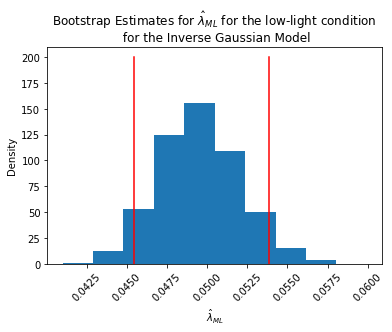

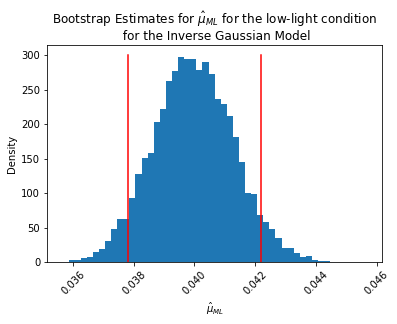

In [67]:
plt.hist(W_low_lam_igauss, density=True)

plt.ylabel('Density')
plt.xlabel('$\hat{\lambda}_{ML}}$')
plt.xticks(rotation=45)
plt.title('Bootstrap Estimates for $\hat{\lambda}_{ML}$ '\
          'for the low-light condition \n for the Inverse Gaussian Model')
plt.plot([lci_lambda_igauss_low, lci_lambda_igauss_low],[0, 200],'-r')
plt.plot([uci_lambda_igauss_low, uci_lambda_igauss_low],[0, 200], '-r')
plt.show()

plt.hist(W_low_mu_igauss, 50, density=True)

plt.ylabel('Density')
plt.xlabel('$\hat{\mu}_{ML}}$')
plt.xticks(rotation=45)
plt.title('Bootstrap Estimates for $\hat{\mu}_{ML}$ '\
          'for the low-light condition \n for the Inverse Gaussian Model')
plt.plot([lci_mu_igauss_low, lci_mu_igauss_low],[0, 300],'-r')
plt.plot([uci_mu_igauss_low, uci_mu_igauss_low],[0, 300],'-r')
plt.show()

4. Compare the ML estimates for the high and low conditions using the bootstrap procedure implemented for the exponential distribution.

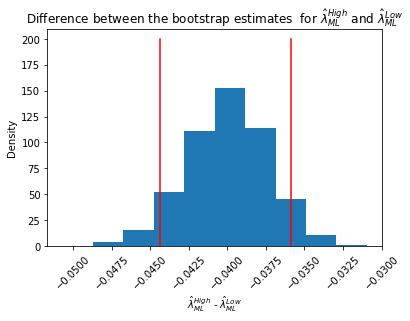

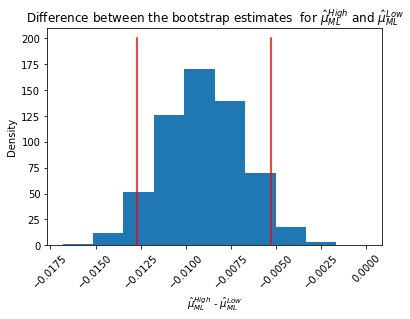

In [66]:
lambda_hats_boot_diff = np.array(W_high_lam_igauss) - np.array(W_low_lam_igauss)
sorted_lambda_hats_boot_diff = np.sort(lambda_hats_boot_diff)
lci_lambda_hats_boot_diff    = sorted_lambda_hats_boot_diff[lci_idx]
uci_lambda_hats_boot_diff    = sorted_lambda_hats_boot_diff[uci_idx]

plt.hist(lambda_hats_boot_diff, density = True)
plt.plot([lci_lambda_hats_boot_diff,lci_lambda_hats_boot_diff],[0, 200], '-r')
plt.plot([uci_lambda_hats_boot_diff,uci_lambda_hats_boot_diff],[0, 200], '-r')

plt.title('Difference between the bootstrap estimates '\
          ' for $\hat{\lambda}_{ML}^{High}$ and '
          '$\hat{\lambda}_{ML}^{Low}$')
plt.xlabel('$\hat{\lambda}_{ML}^{High}$ - $\hat{\lambda}_{ML}^{Low}$')
plt.xticks(rotation=45)
plt.ylabel('Density')
plt.show()

mu_hats_boot_diff        = np.array(W_high_mu_igauss) - np.array(W_low_mu_igauss)
sorted_mu_hats_boot_diff = np.sort(mu_hats_boot_diff)
lci_mu_hats_boot_diff = sorted_mu_hats_boot_diff[lci_idx]
uci_mu_hats_boot_diff = sorted_mu_hats_boot_diff[uci_idx]

plt.hist(mu_hats_boot_diff, density = True)
plt.plot([lci_mu_hats_boot_diff,lci_mu_hats_boot_diff],[0, 200], '-r')
plt.plot([uci_mu_hats_boot_diff,uci_mu_hats_boot_diff],[0, 200], '-r')

plt.title('Difference between the bootstrap estimates '\
          ' for $\hat{\mu}_{ML}^{High}$ and '
          '$\hat{\mu}_{ML}^{Low}$')
plt.xlabel('$\hat{\mu}_{ML}^{High}$ - $\hat{\mu}_{ML}^{Low}$')
plt.xticks(rotation=45)
plt.ylabel('Density')

plt.show()

5. Assess whether the model fits the data well by ploting the theoretical CDF against the empirical CDF for both light conditions.

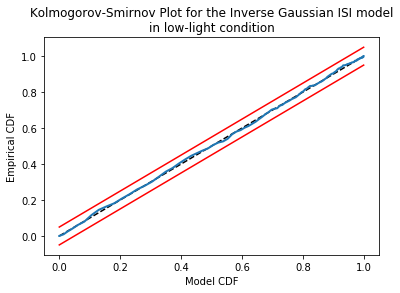

In [55]:
ml_mu_igauss_low_ISIs   = mu_hat_igauss(low_ISIs)
ml_lam_igauss_low_ISIs  = lambda_hat_igauss(low_ISIs)
ISIs = low_ISIs
N    = len(ISIs)
bins = np.arange(0.0001,0.5,0.001)

upper_ks_cis = np.linspace(0,1,N) + 1.36 / np.sqrt(N)
lower_ks_cis = np.linspace(0,1,N) - 1.36 / np.sqrt(N)

counts, _, _ = plt.hist(ISIs, bins, density=False)
plt.close()
len(counts)
condition = 'low-light'
model     = 'Inverse Gaussian'
probs = counts / sum(counts)
low_isis_empirical_cdf = np.cumsum(probs)
low_isis_model_cdf_exp = \
    inv_gauss_cdf(bins,ml_lam_igauss_low_ISIs, ml_mu_igauss_low_ISIs)
plt.plot([0,1], [0,1],'--k')
plt.plot(np.linspace(0,1,N), upper_ks_cis,'-r')
plt.plot(np.linspace(0,1,N), lower_ks_cis,'-r')
plt.plot(low_isis_model_cdf_exp[1:], low_isis_empirical_cdf,linewidth=2.0)
plt.title('Kolmogorov-Smirnov Plot for the '+ model +' ISI model' \
          '\nin ' + condition + ' condition')
plt.ylabel('Empirical CDF')
plt.xlabel('Model CDF')
plt.show()

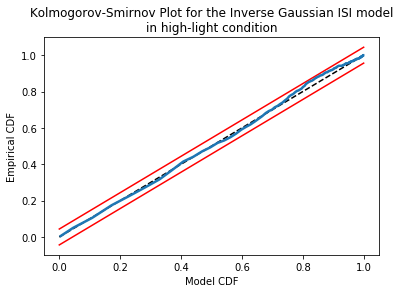

In [56]:
ISIs = high_ISIs
N    = len(ISIs)
bins = np.arange(0.0001,0.5,0.001)

upper_ks_cis = np.linspace(0,1,N) + 1.36 / np.sqrt(N)
lower_ks_cis = np.linspace(0,1,N) - 1.36 / np.sqrt(N)

counts, _, _ = plt.hist(ISIs, bins, density=False)
plt.close()
len(counts)
condition = 'high-light'
model     = 'Inverse Gaussian'
probs     = counts / sum(counts)
high_isis_empirical_cdf = np.cumsum(probs)
high_isis_model_cdf_exp = \
    inv_gauss_cdf(bins,ml_lam_igauss_high_ISIs, ml_mu_igauss_high_ISIs)
plt.plot([0,1], [0,1],'--k')
plt.plot(np.linspace(0,1,N), upper_ks_cis,'-r')
plt.plot(np.linspace(0,1,N), lower_ks_cis,'-r')
plt.plot(high_isis_model_cdf_exp[1:], high_isis_empirical_cdf,linewidth=2.5)
plt.title('Kolmogorov-Smirnov Plot for the '+ model +' ISI model' \
          '\nin ' + condition + ' condition')
plt.ylabel('Empirical CDF')
plt.xlabel('Model CDF')
plt.show()

6. Which of the two models is a better fit to the data?

Based on the KS plots, the Inverse Gaussian model fits the data best.

7. What do the estimated parameters suggest about the ISIs for the two light conditions?

In order to answer this question, let's look once more at the parameters that we estimated for the Inverse Gaussian model if the ISIs.This time, let's convert them to milliseconds for interpretability.

In [61]:
ml_mu_igauss_high_ISIs  = mu_hat_igauss(high_ISIs)*1000 #convert to ms
ml_lam_igauss_high_ISIs = lambda_hat_igauss(high_ISIs)*1000 

ml_mu_igauss_low_ISIs   = mu_hat_igauss(low_ISIs)*1000
ml_lam_igauss_low_ISIs  = lambda_hat_igauss(low_ISIs)*1000

print(ml_mu_igauss_high_ISIs)
print(ml_lam_igauss_high_ISIs)
print(ml_mu_igauss_low_ISIs)
print(ml_lam_igauss_low_ISIs)

30.941974963219625
9.498135387175857
39.98839728438318
49.31816769253932


 The model parameters, $\mu$ and $\lambda$ provide insight about how the spiking activity is changing with respect to the level of light. For the baseline, high-light condition, we have $\hat{\mu} = 30.94 ms$, $\hat{\lambda} = 9.49$ ms. For the low-light condition, we have $\hat{\mu} = 39.98 ms$, $\hat{\lambda} = 49.31$ ms. Therefore, we can see that the mean ISI ($\mu$) is smaller for the low light condition and that the average firing rate ($\lambda$) is also lower. This suggests that there is more bursting activity under the high light condition than under the low light condition.

### Acknowledgements

I am grateful to Dr. Brown for allowing me to base this tutorial on the course notes for <a href = "https://ocw.mit.edu/courses/brain-and-cognitive-sciences/9-07-statistics-for-brain-and-cognitive-science-fall-2016/"> Statistics for Brain and Cognitive Sciences.</a> I am grateful to Dr. Kramer for allowing me to use the data from his book Case Studies in neural data analysis. I am also grateful to Dr. Sassanfar and Dr. Ordoñez for the oportunity to teach this tutorial, and to Sandya Subramanian for helpful feedback in preparing the tutorial. 

### References
  
[1] Ginsburg, K. S., Johnsen, J. A., & Levine, M. W. (1984). Common noise in the firing of neighbouring ganglion cells in goldfish retina. The Journal of physiology, 351(1), 433-450.  
  
[2] Iyengar, S., & Liao, Q. (1997). Modeling neural activity using the generalized inverse Gaussian distribution. Biological Cybernetics, 77(4), 289-295.
    
[3] Levine, M. W. (1991). The distribution of the intervals between neural impulses in the maintained discharges of retinal ganglion cells. Biological cybernetics, 65(6), 459-467.  
  
[4] Eden, Uri T., Kramer, Mark A. (2016). Case studies in neural data analysis. MIT Press.
  
[5] Kass, R. E., Eden, U. T., & Brown, E. N. (2014). Analysis of neural data (Vol. 491). New York: Springer
  
[6] Massey Jr, F. J. (1951). The Kolmogorov-Smirnov test for goodness of fit. Journal of the American statistical Association, 46(253), 68-78.